<a href="https://colab.research.google.com/github/juandiego2205/Biosenales/blob/main/Proyecto2/Proyecto2_KevinGarciaj_JuanCaguasango.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##PROYECTO 2

In [ ]:
#importacion de las librerias necesarias para el calculo estadistico de las señales
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import seaborn as sns
from scipy import stats
from scipy.stats import mannwhitneyu
from google.colab import drive
from scipy.fftpack import fft as ft;
import scipy.io as sio;
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/Biosenales_Proyectos/P2/ECGDataDenoised.zip .
!unzip ECGDataDenoised.zip

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: ECGDataDenoised/MUSE_20180116_125802_57000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125812_73000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125822_43000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125825_58000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125842_09000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125845_27000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125847_39000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125906_02000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125918_29000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125919_34000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125921_43000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125925_64000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125946_45000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125948_54000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_130000_80000.csv  
  i

In [ ]:
DatosBase=pd.read_excel('/content/drive/MyDrive/Biosenales_Proyectos/P2/Diagnostics.xlsx')
df_filtradoAfib=DatosBase[DatosBase['Rhythm'] == 'AFIB']
ListaPacientes1 = df_filtradoAfib['FileName'].tolist()
df_filtradoSB=DatosBase[DatosBase['Rhythm'] == 'SB']
ListaPacientes2 = df_filtradoSB['FileName'].tolist()
Fs = 500
muestras = np.arange(5000)
tiempo = muestras / Fs


3889

In [ ]:
def procesar_ecg(lista_pacientes, df_filtrado, lista_registro, lista_estados, lista_valores_ecg, archivo_zip):
    nueva_lista = [f"{elemento}.csv" for elemento in lista_pacientes]  # Generar lista de nombres de archivo

    with zipfile.ZipFile(archivo_zip, 'r') as zip_ref:
        # Iterar sobre cada archivo en el ZIP
        for archivo in zip_ref.namelist():
            # Verificar si el nombre del archivo está en la lista
            clean_filename = archivo.replace("ECGDataDenoised/", "")
            if clean_filename in nueva_lista:
                # Extraer el archivo
                zip_ref.extract(archivo)
                # Filtrar el DataFrame
                df_filtrado2 = df_filtrado[df_filtrado['FileName'] == clean_filename]
                estado = df_filtrado2['Rhythm'].values
                lista_estados.append(estado)
                lista_registro.append(clean_filename)

                # Leer datos del archivo extraído
                data_sujetos = pd.read_csv(archivo, delimiter=',', names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])
                data_sujetos_n = data_sujetos['II'].values
                lista_valores_ecg.append(data_sujetos_n)


In [ ]:

def tendencia(x):
  k = len(x)  # Cantidad de puntos
  # Ajuste polinomial de grado n (ajuste con un polinomio de grado n)
  # Grado del polinomio, ajusta según tus necesidades
  p = np.polyfit(range(k), x, 2)  # Coeficientes del polinomio
  x1 = np.polyval(p, range(k))     # Evaluación del polinomio para obtener x1(i)

  # Aplicamos la fórmula para calcular el error cuadrático promedio
  delta_n = (1 / k) * np.sum((x - x1) ** 2)
  x_detrend = x - x1
  return x_detrend


In [ ]:
def compresion(x):
  x_min = np.min(x)
  x_max = np.max(x)
  t = np.linspace(0, len(x)/100, len(x))  # Vector de tiempo
  # Aplicar el método de compresión
  s = (x - x_min) / (x_max - x_min)
  return s

In [ ]:
def EspectroPotencia(signal):
  Fs = 500
  t = np.arange(5000)
  fft_healthy = np.fft.fft(signal)
  power_healthy = np.abs(fft_healthy)**2
  freqs = np.fft.fftfreq(len(t), 1 / Fs)
  freqs = freqs[:len(freqs)//2]
  power_healthy = power_healthy[:len(power_healthy)//2]

  return freqs, power_healthy




In [ ]:

def BispectrumAndBicoherencia(signal, fs, nfft): #window='hann', #overlap=0.5):
    segments = []
    indices = range(0, len(signal) - nfft + 1, nfft)
    for i in indices:
        segment = signal[i:i + nfft]
        segments.append(segment)
    segments = np.array(segments)
    num_segments = segments.shape[0]
    fft_segments = np.fft.fft(segments, n=nfft, axis=1)
    fft_segments = fft_segments[:, :nfft // 2]

    B = np.zeros((nfft // 2, nfft // 2), dtype=complex)
    B2= np.zeros((nfft // 2, nfft // 2), dtype=complex)

    for k in range(num_segments):
        S = fft_segments[k, :]
        for f1 in range(nfft // 2):
            for f2 in range(nfft // 2 - f1):
                f3 = f1 + f2
                B[f1, f2] += S[f1] * S[f2] * np.conj(S[f3])
                B2[f1, f2] += np.abs(S[f1] * S[f2] * np.conj(S[f3]))

    B = np.abs(B) / B2  # Esto podría causar un RuntimeWarning si B2 es cero
    return B

def Simetria(x):
  bic_sim = np.zeros((10, 20))
  for f1 in range(20):
      for f2 in range(f1, 20 - f1):
          bic_sim[f1, f2] = x[f1, f2]
  return bic_sim

In [ ]:
def graficar_ecg(tiempo, datos, titulo, posicion):
    plt.subplot(2, 1, posicion)
    plt.plot(tiempo, datos)
    plt.title(titulo)
    plt.ylabel("ECG")
    plt.xlabel("Tiempo (s)")

def graficar_espectro(x, y, titulo, posicion):
    plt.subplot(2, 1, posicion)
    plt.plot(x, y, color='green')
    plt.title(titulo)
    plt.xlabel("Frecuencia (Hz)")
    plt.ylabel("Potencia")
    plt.xlim(-1, 80)

In [ ]:
def calcular_datos(lista_valores_ecg):
    datos = []
    datos_y = []
    for i in range(len(lista_valores_ecg)):
        PrimerDetrend = tendencia(lista_valores_ecg[i])
        Com = compresion(PrimerDetrend)
        SegundoDetrend = tendencia(Com)
        x, y = EspectroPotencia(SegundoDetrend)
        datos.append(x)
        datos_y.append(y)
    return datos, datos_y
def normalizar_datos(datos):
    max_length = max(len(arr) for arr in datos)
    return [np.pad(arr, (0, max_length - len(arr)), constant_values=np.nan) for arr in datos]

In [ ]:
def graficar_bicoherencia(bicoherencia, titulo):
    plt.imshow(bicoherencia, extent=(0, 20, 0, 10), origin='lower', cmap='viridis', aspect='auto')
    plt.colorbar(label='Bicoherencia')
    plt.title(titulo)
    plt.xlabel('Frecuencia f1')
    plt.ylabel('Frecuencia f2')
    plt.xticks(np.arange(0, 21, 2))  # Ajuste de ticks en el eje x
    plt.yticks(np.arange(0, 11, 1))  # Ajuste de ticks en el eje y
    plt.grid(False)

In [ ]:
def eliminar_outliers(data):
    # Calcular cuartiles y rango intercuartil
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    # Definir límites para detectar outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Filtrar los datos para eliminar los outliers
    return data[(data >= lower_bound) & (data <= upper_bound)]

In [ ]:
# Inicializar listas
ListaRegistro1 = []
ListaEstados1 = []
ListaValoresECG1 = []

ListaRegistro2 = []
ListaEstados2 = []
ListaValoresECG2 = []
# Procesar los datos de los dos grupos
procesar_ecg(ListaPacientes1, df_filtradoAfib, ListaRegistro1, ListaEstados1, ListaValoresECG1, "/content/ECGDataDenoised.zip")
procesar_ecg(ListaPacientes2, df_filtradoSB, ListaRegistro2, ListaEstados2, ListaValoresECG2, "/content/ECGDataDenoised.zip")


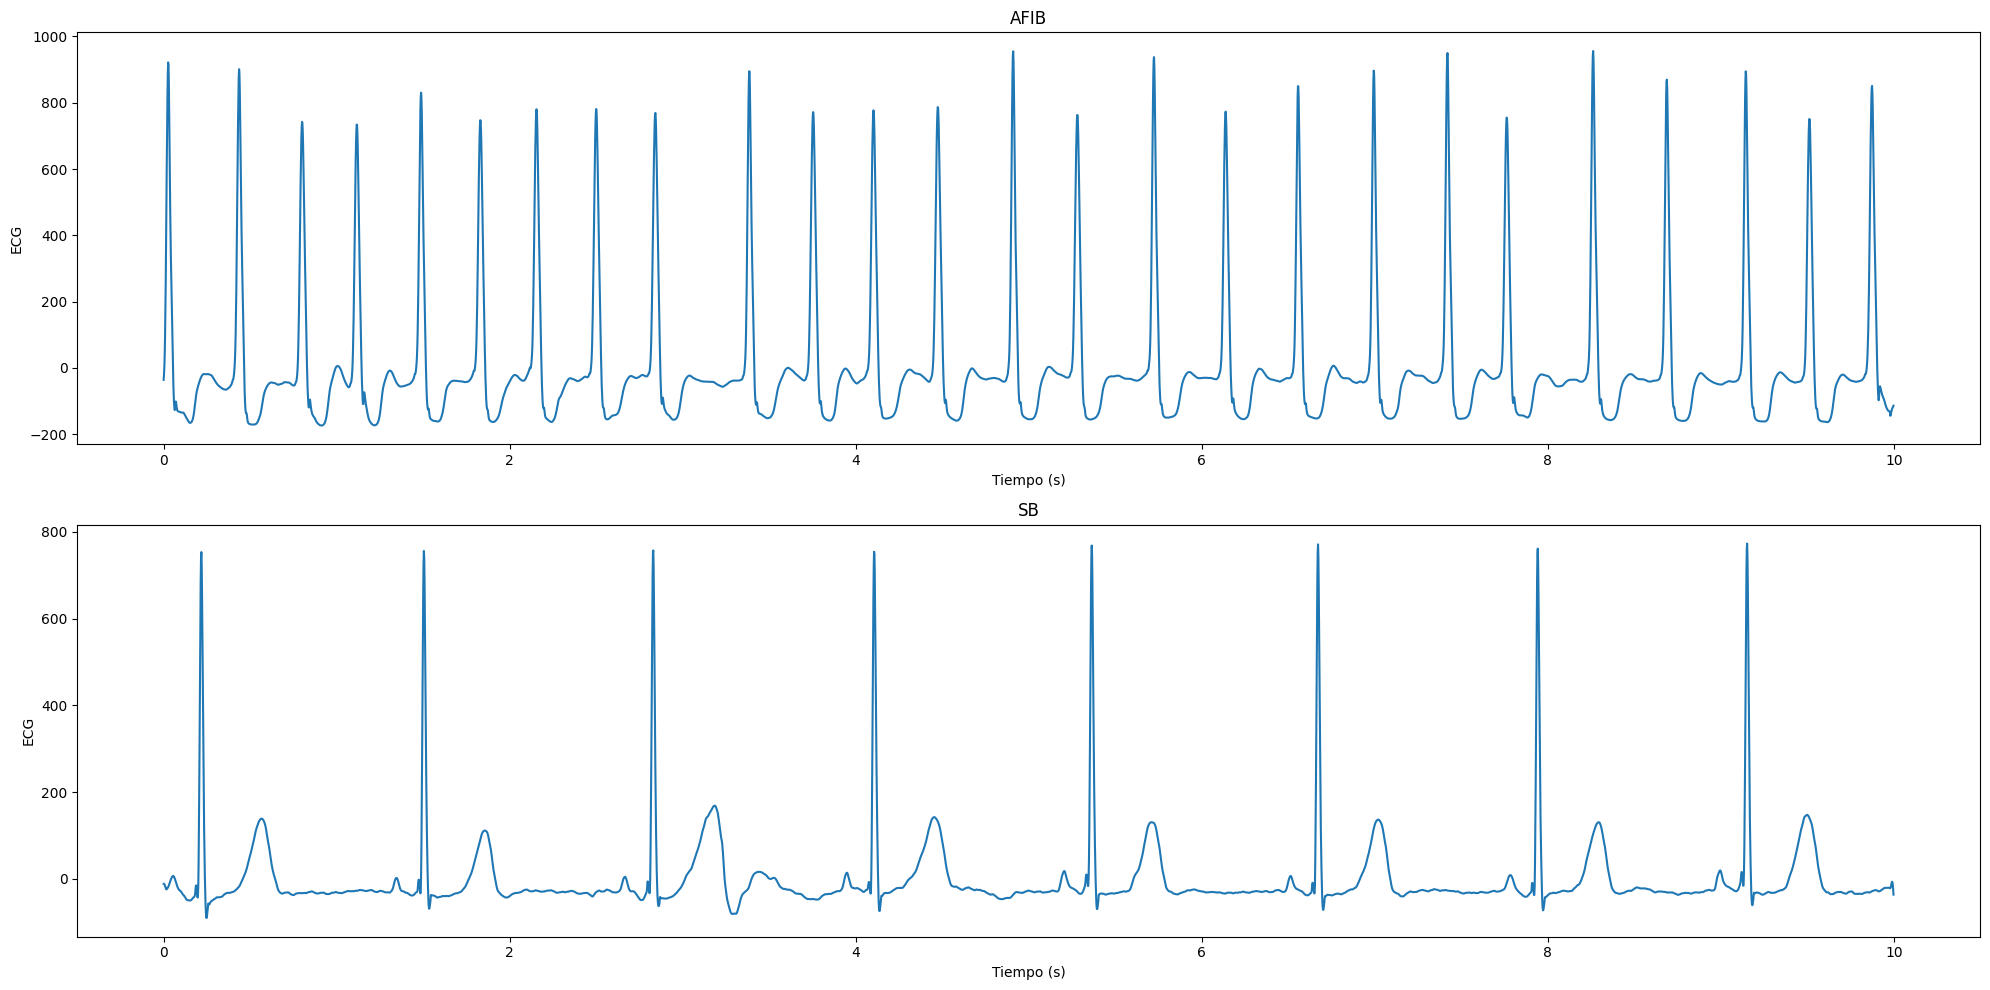

In [ ]:
PrimerDetrend1 = tendencia(ListaValoresECG1[400])  # Obtener la tendencia para AFIB
PrimerDetrend2 = tendencia(ListaValoresECG2[400])  # Obtener la tendencia para SB
plt.figure(figsize=(20, 10))
graficar_ecg(tiempo, PrimerDetrend1, "AFIB", 1)
graficar_ecg(tiempo, PrimerDetrend2, "SB", 2)
plt.tight_layout()
plt.show()

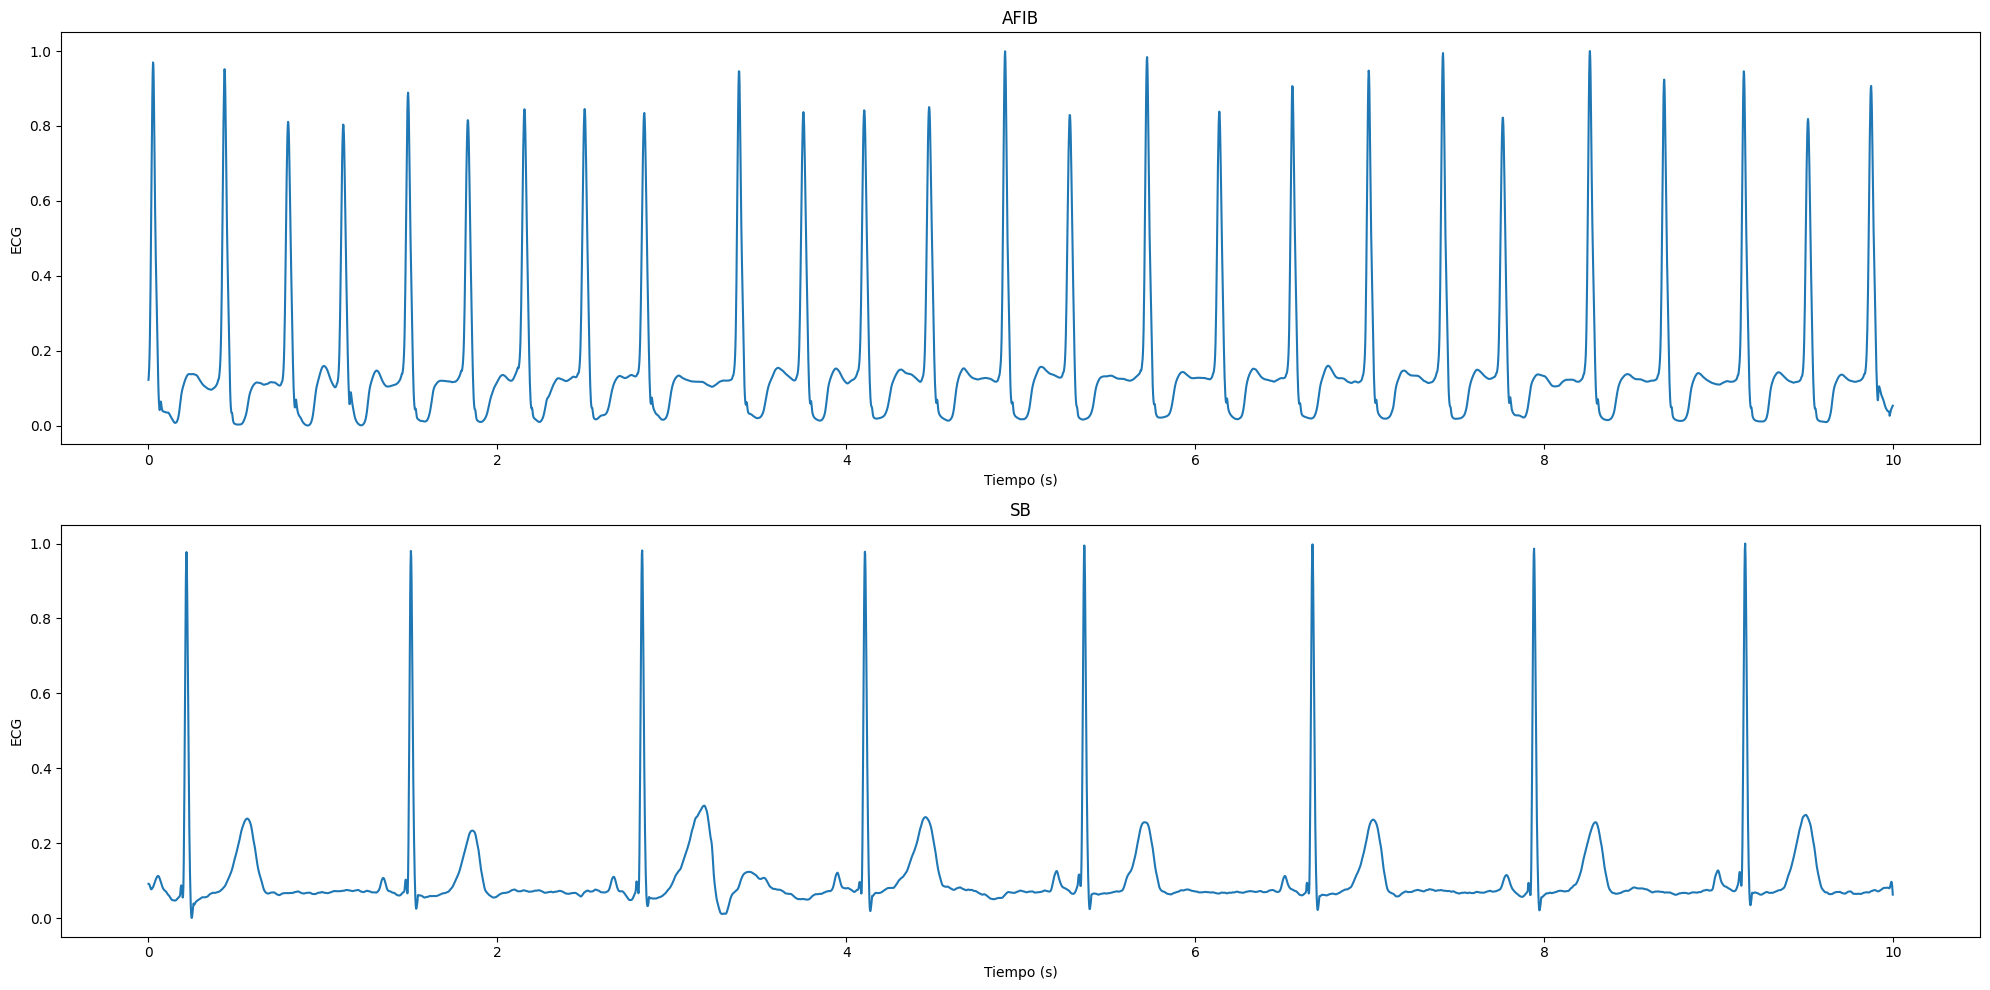

In [ ]:
com = compresion(PrimerDetrend1)
com2 = compresion(PrimerDetrend2)
plt.figure(figsize=(20, 10))
graficar_ecg(tiempo, com, "AFIB", 1)
graficar_ecg(tiempo, com2, "SB", 2)
plt.tight_layout()
plt.show()

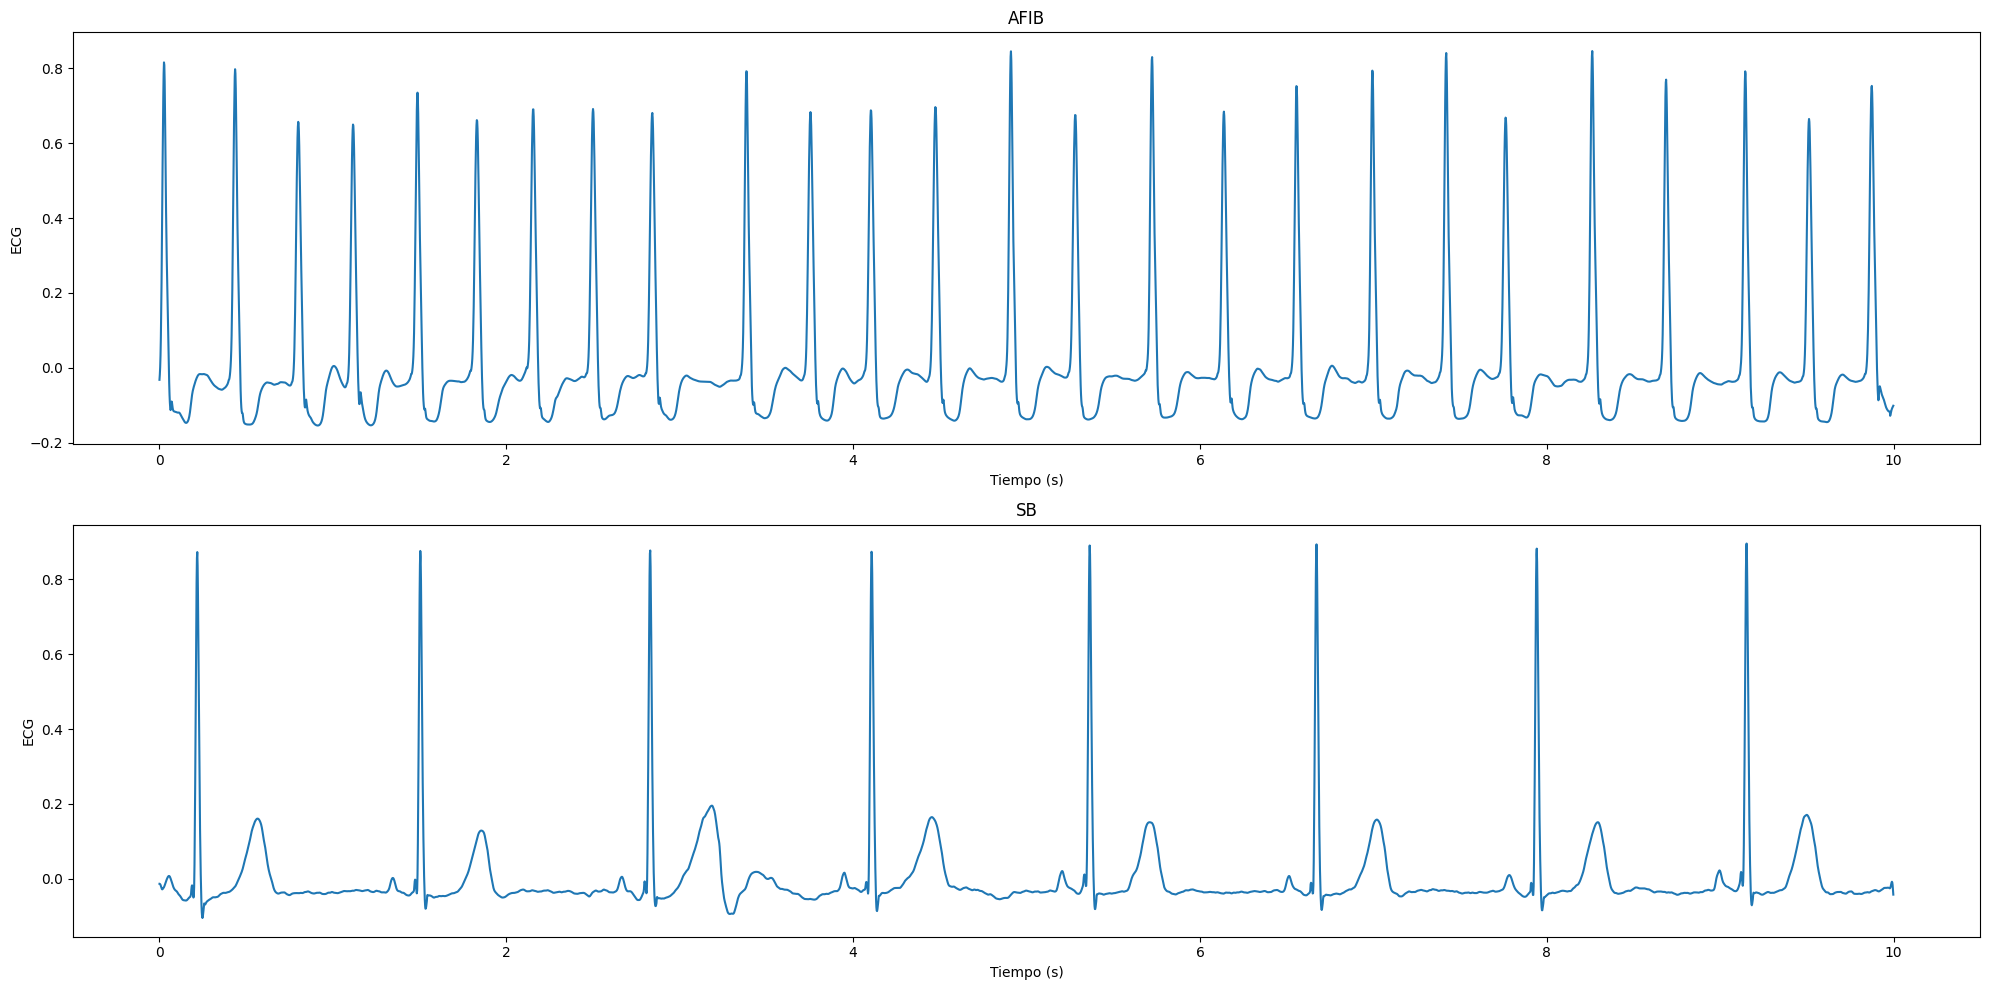

In [ ]:
SegundoDetrend1 = tendencia(com)
SegundoDetrend2= tendencia(com2)
plt.figure(figsize=(20, 10))
graficar_ecg(tiempo, SegundoDetrend1, "AFIB", 1)
graficar_ecg(tiempo, SegundoDetrend2, "SB", 2)
plt.tight_layout()
plt.show()

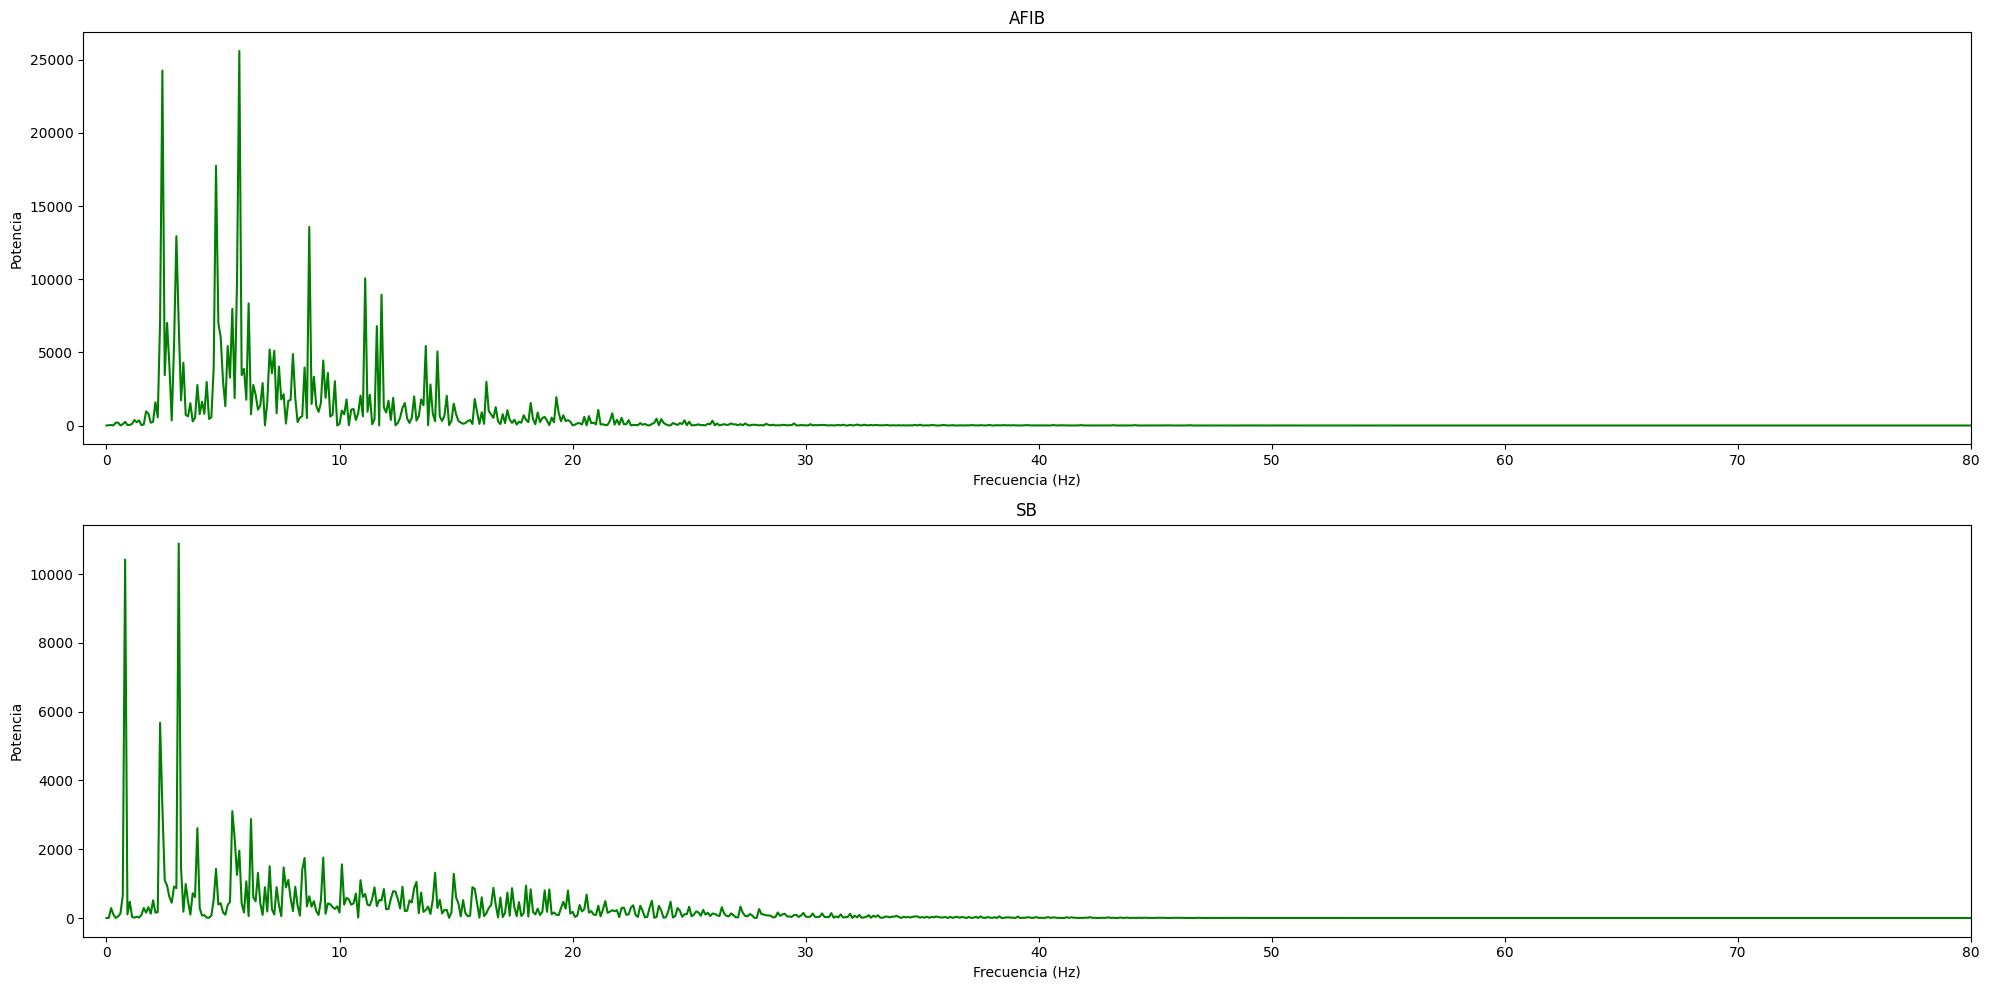

In [ ]:
x, y = EspectroPotencia(SegundoDetrend1)
x2, y2 = EspectroPotencia(SegundoDetrend2)
plt.figure(figsize=(20, 10))
graficar_espectro(x, y, "AFIB", 1)
graficar_espectro(x2, y2, "SB", 2)
plt.tight_layout()
plt.show()

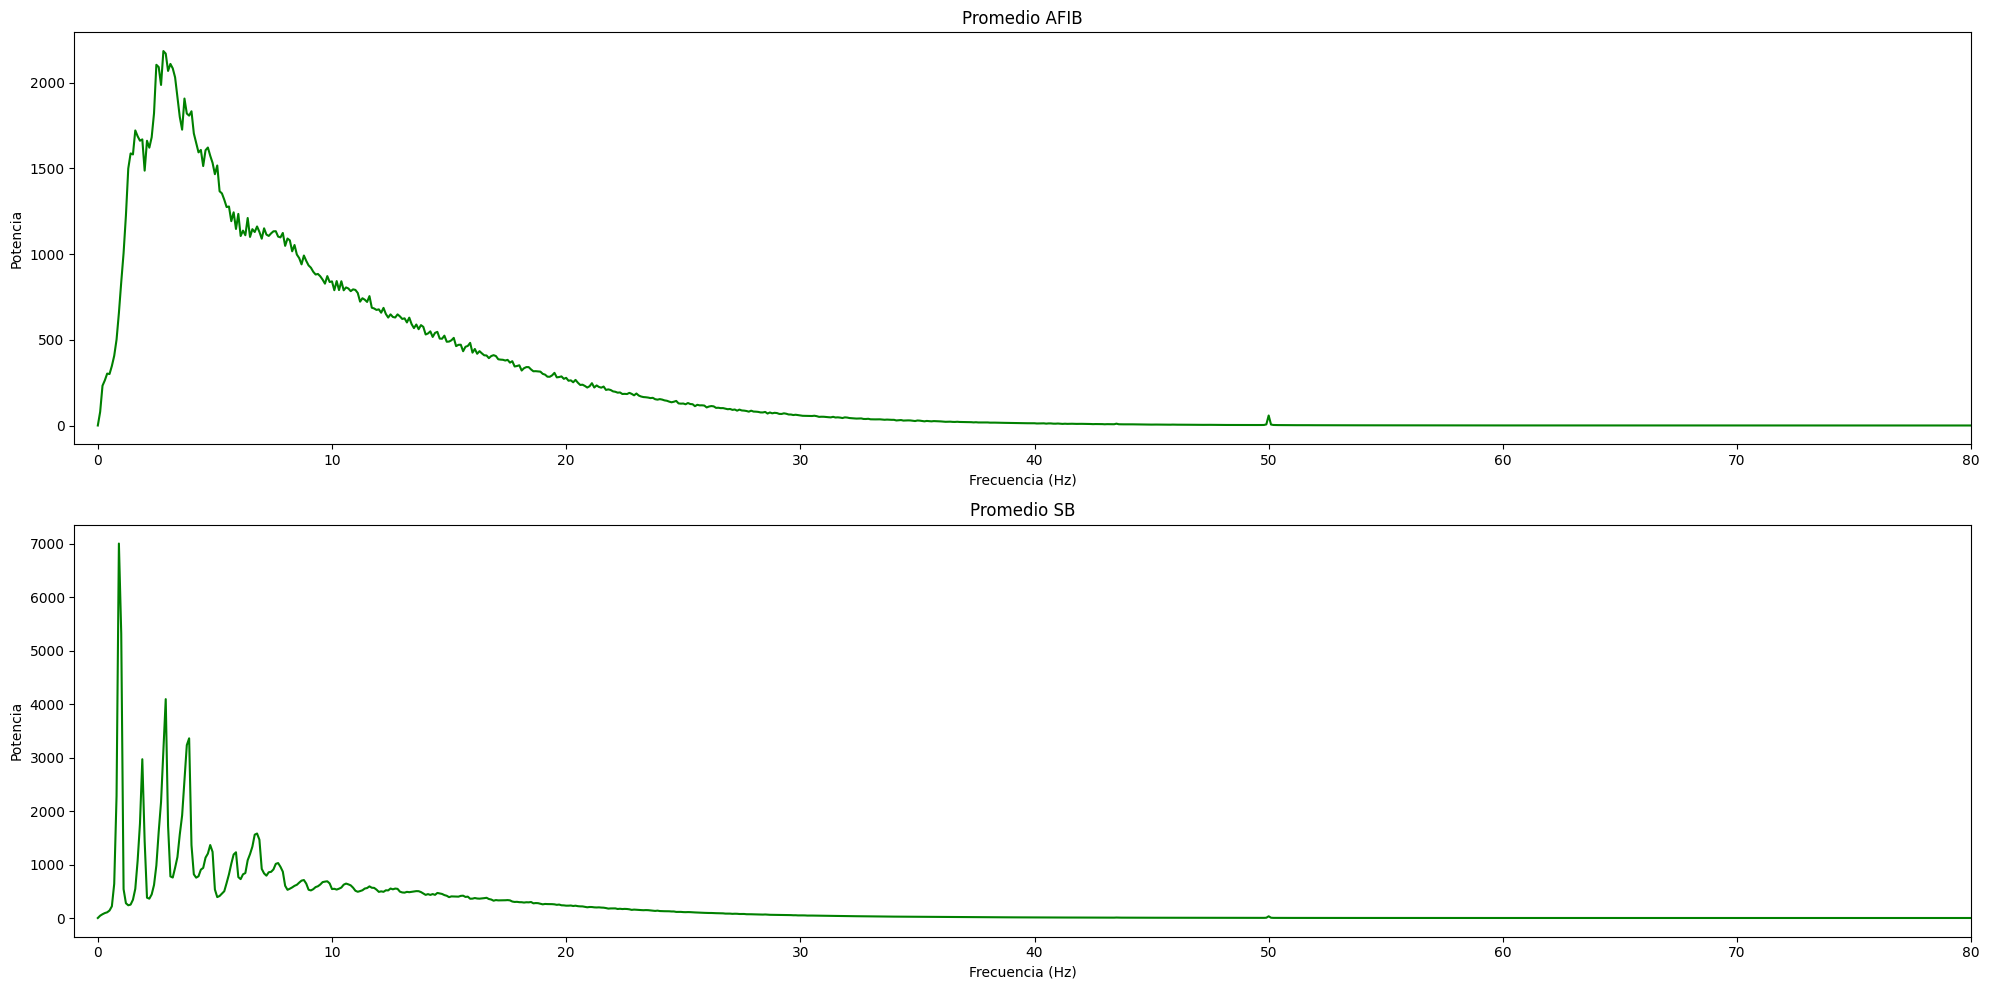

In [ ]:
DatosY1 = []
DatosY2 = []
Datos1 = []
Datos2 = []
Datos1, DatosY1 = calcular_datos(ListaValoresECG1)
Datos2, DatosY2 = calcular_datos(ListaValoresECG2)
normalized_datos1 = normalizar_datos(Datos1)
normalized_datos2 = normalizar_datos(Datos2)
normalized_y1 = normalizar_datos(DatosY1)
normalized_y2 = normalizar_datos(DatosY2)
D1m = np.nanmean(normalized_datos1, axis=0)
D2m = np.nanmean(normalized_datos2, axis=0)
D1my = np.nanmean(normalized_y1, axis=0)
D2my = np.nanmean(normalized_y2, axis=0)
plt.figure(figsize=(20, 10))
graficar_espectro(D1m, D1my, "Promedio AFIB",1)
graficar_espectro(D2m, D2my, "Promedio SB",2)
plt.tight_layout()
plt.show()


<ipython-input-30-c04158f0a863>:23: RuntimeWarning: invalid value encountered in divide
  B = np.abs(B) / B2  # Esto podría causar un RuntimeWarning si B2 es cero
<ipython-input-30-c04158f0a863>:30: ComplexWarning: Casting complex values to real discards the imaginary part
  bic_sim[f1, f2] = x[f1, f2]


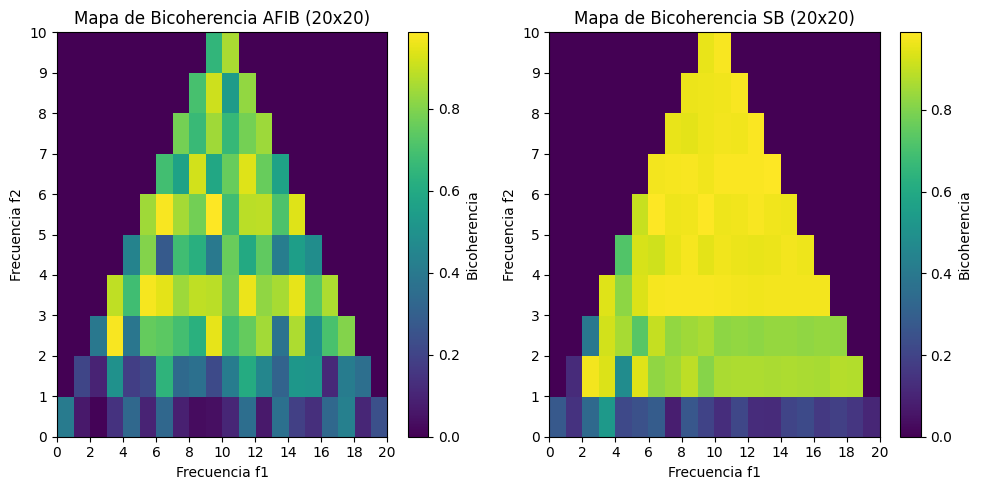

In [ ]:
fs = 500
nfft = 500
B3 = BispectrumAndBicoherencia(SegundoDetrend1, fs, nfft)
B4 = Simetria(B3)
B5 = BispectrumAndBicoherencia(SegundoDetrend2, fs, nfft)
B6 = Simetria(B5)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
graficar_bicoherencia(B4, 'Mapa de Bicoherencia AFIB (20x20)')
plt.subplot(1, 2, 2)
graficar_bicoherencia(B6, 'Mapa de Bicoherencia SB (20x20)')
plt.tight_layout()
plt.show()


In [ ]:
fs=500
nfft=500
listaNewData2=[];
listaNewData1=[];
Bicoherencia1=[]
Bicoherencia2=[]
umbrbral=np.sqrt(9.2/(2*nfft))
#Carga de Datos SB
for i in range(len(ListaValoresECG2)):
  PrimerDetrend=tendencia(ListaValoresECG2[i])
  Com=compresion(PrimerDetrend)
  SegundoDetrend=tendencia(Com)
  x,y=EspectroPotencia(SegundoDetrend)
  indice_maximo = np.argmax(y)
  maximaF=x[indice_maximo]
  b1=BispectrumAndBicoherencia(SegundoDetrend, fs, nfft)
  b2=Simetria(b1)
  Bicoherencia1.append(b2)
  sumaF=np.sum(b2>0.95)
  listaNewData2.append([ListaRegistro2[i],ListaEstados2[i],sumaF,maximaF])




NameError: name 'ListaValoresECG2' is not defined

In [ ]:
# carga de datos AFIB
for i in range(len(ListaValoresECG1)):
  PrimerDetrend=(tendencia(ListaValoresECG1[i]))
  Com=compresion(PrimerDetrend)
  SegundoDetrend=tendencia(Com)
  x,y=EspectroPotencia(SegundoDetrend)
  indice_maximo = np.argmax(y)
  maximaF=x[indice_maximo]
  b1=BispectrumAndBicoherencia(SegundoDetrend, fs, nfft)
  b2=Simetria(b1)
  Bicoherencia2.append(b2)
  sumaF=np.sum(b2>0.95)
  listaNewData1.append([ListaRegistro1[i],ListaEstados1[i],sumaF,maximaF])

In [ ]:
promedio_BAFIB= np.mean(Bicoherencia2, axis=0)
plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.imshow(promedio_BAFIB, extent=(0, 20, 0, 10), origin='lower', cmap='viridis', aspect='auto')
plt.colorbar(label='Bicoherencia')
plt.title('Mapa de Bicoherencia AFIB(20x20)')
plt.xlabel('Frecuencia f1')
plt.ylabel('Frecuencia f2')
plt.xticks(np.arange(0, 21, 2))  # Ajuste de ticks en el eje x
plt.yticks(np.arange(0, 11, 1))  # Ajuste de ticks en el eje y
plt.grid(False)  # Desactiva la cuadrícula si no es necesaria
promedio_BSB= np.mean(Bicoherencia1, axis=0)
plt.subplot(1,2,2)
plt.imshow(promedio_BSB, extent=(0, 20, 0, 10), origin='lower', cmap='viridis', aspect='auto')
plt.colorbar(label='Bicoherencia')
plt.title('Mapa de Bicoherencia SB(20x20)')
plt.xlabel('Frecuencia f1')
plt.ylabel('Frecuencia f2')
plt.xticks(np.arange(0, 21, 2))  # Ajuste de ticks en el eje x
plt.yticks(np.arange(0, 11, 1))  # Ajuste de ticks en el eje y
plt.grid(False)  # Desactiva la cuadrícula si no es necesaria
plt.show()
plt.show()

Dimensiones de Bicoherencia2: (1780, 1)
Dimensiones de Bicoherencia1: (3889, 1)
Tamaño de promedio_BAFIB: (1,)
Tamaño de promedio_BSB: (1,)
promedio_BAFIB no tiene el tamaño correcto: 1
promedio_BSB no tiene el tamaño correcto: 1
No se puede mostrar la imagen: las matrices no tienen el tamaño correcto.


In [ ]:
Bicoherencia1=np.array(int(Bicoherencia1))
Bicoherencia2=np.array(int(Bicoherencia2))
promedio_BAFIB= np.mean(Bicoherencia2, axis=0)
plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.imshow(promedio_BAFIB, extent=(0, 20, 0, 10), origin='lower', cmap='viridis', aspect='auto')
plt.colorbar(label='Bicoherencia')
plt.title('Mapa de Bicoherencia AFIB(20x20)')
plt.xlabel('Frecuencia f1')
plt.ylabel('Frecuencia f2')
plt.xticks(np.arange(0, 21, 2))  # Ajuste de ticks en el eje x
plt.yticks(np.arange(0, 11, 1))  # Ajuste de ticks en el eje y
plt.grid(False)  # Desactiva la cuadrícula si no es necesaria
promedio_BSB= np.mean(Bicoherencia1, axis=0)
plt.subplot(1,2,2)
plt.imshow(promedio_BSB, extent=(0, 20, 0, 10), origin='lower', cmap='viridis', aspect='auto')
plt.colorbar(label='Bicoherencia')
plt.title('Mapa de Bicoherencia SB(20x20)')
plt.xlabel('Frecuencia f1')
plt.ylabel('Frecuencia f2')
plt.xticks(np.arange(0, 21, 2))  # Ajuste de ticks en el eje x
plt.yticks(np.arange(0, 11, 1))  # Ajuste de ticks en el eje y
plt.grid(False)  # Desactiva la cuadrícula si no es necesaria
plt.show()
plt.show()

NameError: name 'Bicoherencia1' is not defined

In [ ]:
df1 = pd.DataFrame(listaNewData1, columns=["REGISTRO", "ESTADO", "sFSB", "FMP"])
df1["ESTADO"] = "AFIB"
df2 = pd.DataFrame(listaNewData2, columns=["REGISTRO", "ESTADO", "sFSB", "FMP"])
df2["ESTADO"] = "SB"
df_combinado = pd.concat([df1, df2], ignore_index=True)
df_combinado.to_excel("DataFrame_SujetosP2.xlsx", index=False)
df_SBP = pd.DataFrame({'Matriz': Bicoherencia1})
df_SBP.to_excel("MatrizSBP.xlsx", index=False)
df_AFIB = pd.DataFrame({'Matriz': Bicoherencia2})
df_AFIB.to_excel("MatrizAFIB.xlsx", index=False)


NameError: name 'listaNewData1' is not defined

## PARTE DE DATAFRAME DESDE EL EXCEL

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import seaborn as sns
from scipy import stats
from scipy.stats import mannwhitneyu
from google.colab import drive
from scipy.fftpack import fft as ft;
import scipy.io as sio;
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
Archivo=pd.read_excel('/content/drive/MyDrive/Biosenales_Proyectos/P2/DataFrame_SujetosP2.xlsx')

In [ ]:
from IPython.display import HTML, display

# Estilo mejorado para el DataFrame
Hsujetos = (
    Archivo.style
    .set_table_styles(
        [
            {
                'selector': 'thead th',
                'props': [
                    ('background-color', '#2c3e50'),
                    ('color', 'white'),
                    ('font-weight', 'bold'),
                    ('border', '1px solid #2980b9'),
                    ('text-align', 'center'),
                    ('vertical-align', 'middle')
                ]
            },
            {
                'selector': 'caption',
                'props': [
                    ('caption-side', 'top'),
                    ('font-size', '22px'),
                    ('background-color', '#2980b9'),
                    ('color', 'white'),
                    ('font-weight', 'bold'),
                    ('text-align', 'center'),
                    ('padding', '12px')
                ]
            },
            {
                'selector': 'tbody td',
                'props': [
                    ('border', '1px solid #bdc3c7'),
                    ('padding', '8px'),
                    ('text-align', 'center'),
                    ('vertical-align', 'middle')
                ]
            }
        ]
    )
    .background_gradient(cmap='Blues')
    .set_caption("SUJETOS")
    .set_table_attributes('style="width: 100%; max-width: 1500px; margin: auto;"')  # Ajusta el ancho del DataFrame
)

# Convertir a HTML y mostrar centrado
display(HTML(f"<div style='text-align: center; width: 100%;'>{Hsujetos.to_html()}</div>"))


In [ ]:
SB=Archivo[Archivo['ESTADO'] == 'SB']
AFIB=Archivo[Archivo['ESTADO'] == 'AFIB']




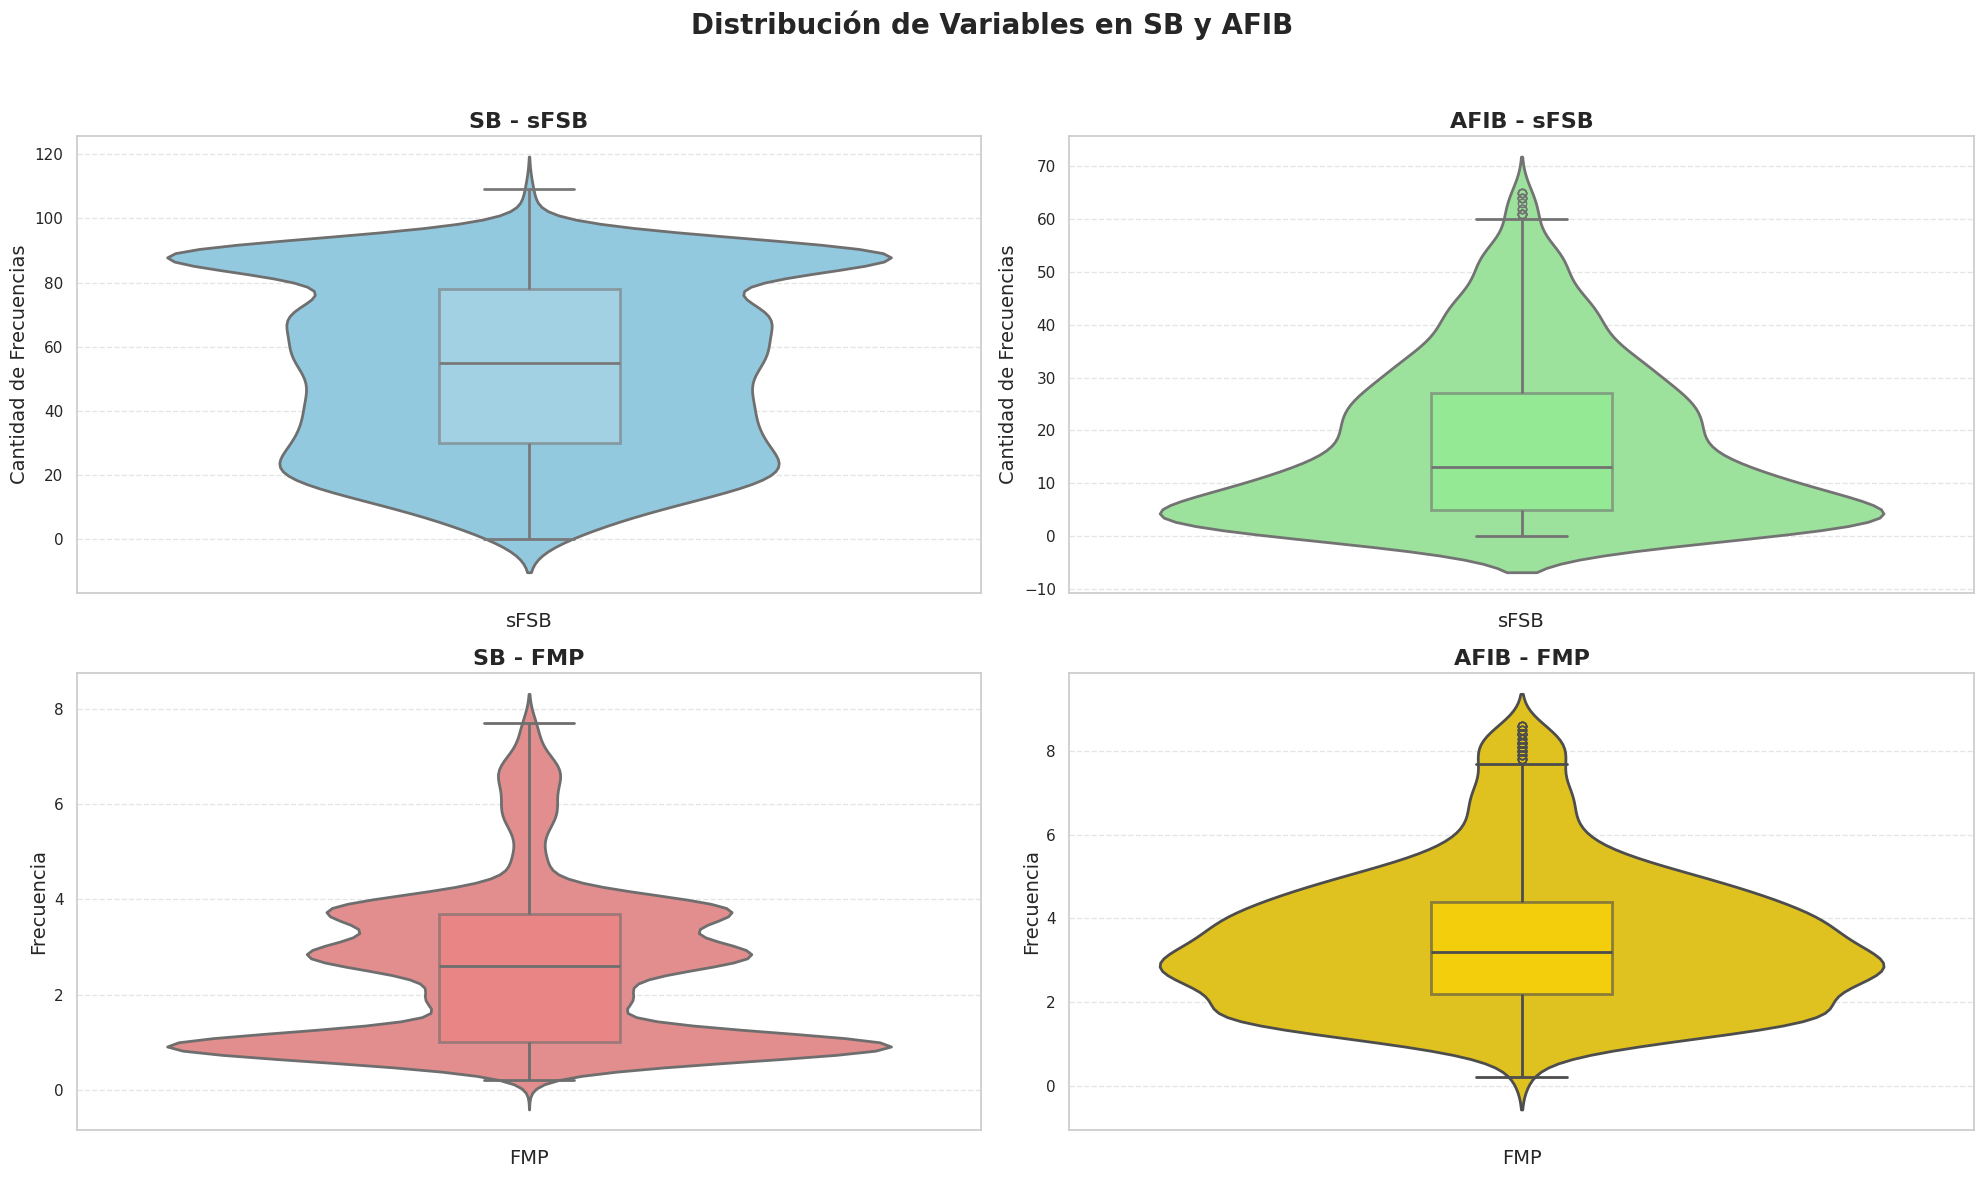

In [ ]:
SB_sFSB_clean = eliminar_outliers(SB["sFSB"])
AFIB_sFSB_clean = eliminar_outliers(AFIB["sFSB"])
SB_FMP_clean = eliminar_outliers(SB["FMP"])
AFIB_FMP_clean = eliminar_outliers(AFIB["FMP"])

# Establecer el estilo de Seaborn
sns.set(style="whitegrid", palette="pastel")

# Datos y títulos para los gráficos
data_titles = [
    (SB_sFSB_clean, "SB - sFSB", "sFSB", "Cantidad de Frecuencias", "skyblue", "lightblue"),
    (AFIB_sFSB_clean, "AFIB - sFSB", "sFSB", "Cantidad de Frecuencias", "lightgreen", "lightgreen"),
    (SB_FMP_clean, "SB - FMP", "FMP", "Frecuencia", "lightcoral", "lightcoral"),
    (AFIB_FMP_clean, "AFIB - FMP", "FMP", "Frecuencia", "gold", "gold")
]

# Graficar sin outliers
plt.figure(figsize=(20, 12))
plt.suptitle("Distribución de Variables en SB y AFIB", fontsize=20, fontweight='bold')

for i, (data, title, xlabel, ylabel, violin_color, box_color) in enumerate(data_titles):
    plt.subplot(2, 2, i + 1)
    sns.violinplot(data=data, color=violin_color, inner=None, linewidth=2)
    sns.boxplot(data=data, width=0.2, boxprops=dict(facecolor=box_color, alpha=0.6), color=box_color, linewidth=2)
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajustar el espacio para el título general
plt.show()


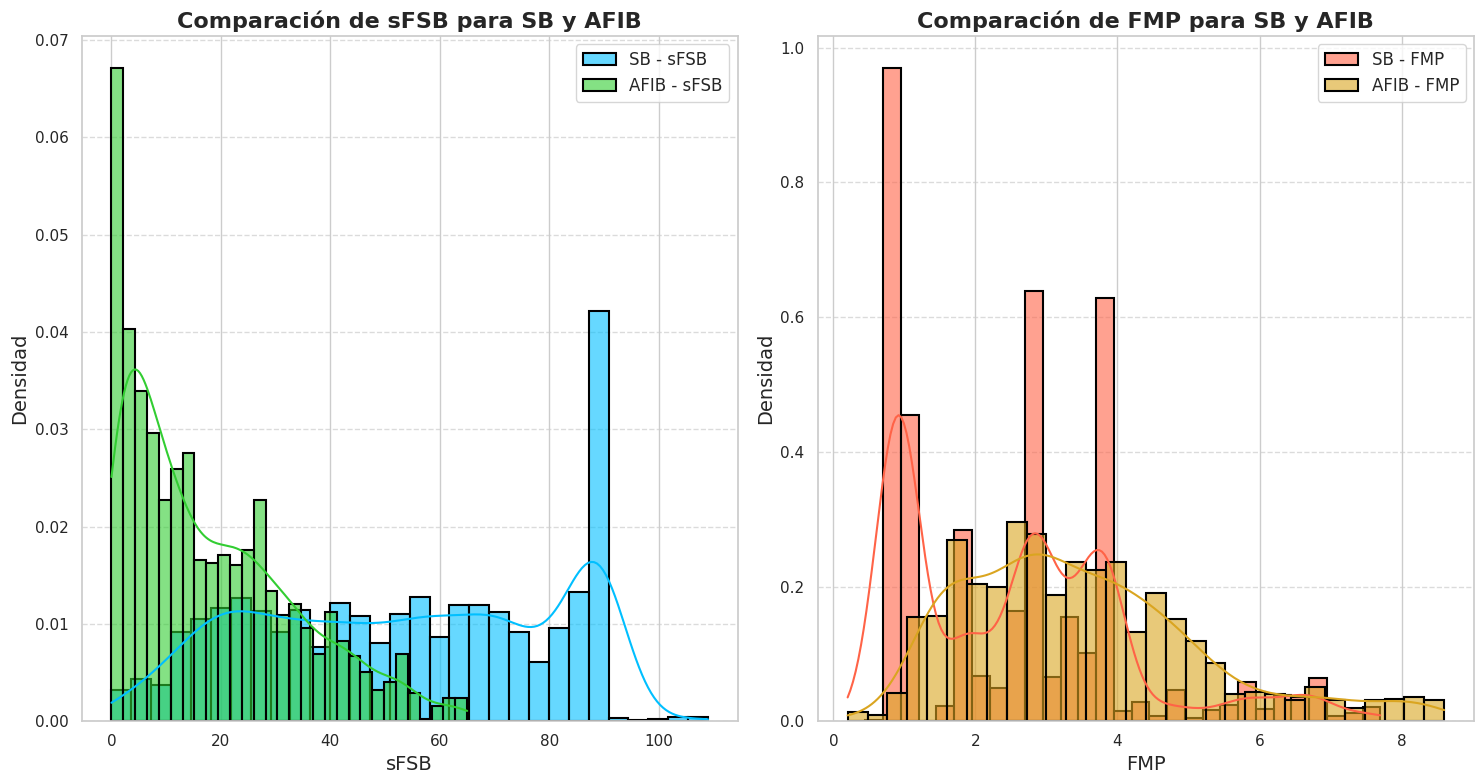

In [ ]:
variables = [
    ("sFSB", SB["sFSB"], AFIB["sFSB"]),
    ("FMP", SB["FMP"], AFIB["FMP"])
]

cleaned_data = [(eliminar_outliers(sb), eliminar_outliers(afib)) for _, sb, afib in variables]

# Graficar histogramas y KDE sin outliers
plt.figure(figsize=(15, 8))
sns.set(style="whitegrid")  # Estilo general de la gráfica

# Configuración de los títulos y colores para las gráficas
titles = ["Comparación de sFSB para SB y AFIB", "Comparación de FMP para SB y AFIB"]
colors = [("deepskyblue", "limegreen"), ("tomato", "goldenrod")]

for i, (sb_clean, afib_clean) in enumerate(cleaned_data):
    plt.subplot(1, 2, i + 1)
    sns.histplot(sb_clean, bins=30, color=colors[i][0], kde=True, stat="density", label=f"SB - {variables[i][0]}", alpha=0.6, linewidth=1.5, edgecolor='black')
    sns.histplot(afib_clean, bins=30, color=colors[i][1], kde=True, stat="density", label=f"AFIB - {variables[i][0]}", alpha=0.6, linewidth=1.5, edgecolor='black')

    plt.title(titles[i], fontsize=16, fontweight='bold')
    plt.xlabel(variables[i][0], fontsize=14)
    plt.ylabel("Densidad", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajustar el layout
plt.tight_layout()
plt.show()



In [ ]:
ks_stat_sFSB, ks_p_sFSB = stats.kstest(SB['sFSB'], 'norm', args=(SB['sFSB'].mean(), SB['sFSB'].std()))
ks_stat_FMP, ks_p_FMP = stats.kstest(SB['FMP'], 'norm', args=(SB['FMP'].mean(), SB['FMP'].std()))
ks_stat_sFSBA, ks_p_sFSBA = stats.kstest(AFIB['sFSB'], 'norm', args=(AFIB['sFSB'].mean(), AFIB['sFSB'].std()))
ks_stat_FMPA, ks_p_FMPA = stats.kstest(AFIB['FMP'], 'norm', args=(AFIB['FMP'].mean(), AFIB['FMP'].std()))

# Crear un DataFrame con los resultados
data = {
    'Estado': ['SB', 'SB', 'AFIB', 'AFIB'],
    'Variable': ['sFSB', 'FMP', 'sFSB', 'FMP'],
    'Statistic': [ks_stat_sFSB, ks_stat_FMP, ks_stat_sFSBA, ks_stat_FMPA],
    'p-value': [ks_p_sFSB, ks_p_FMP, ks_p_sFSBA, ks_p_FMPA],
    'Normalidad': [
        'No se rechaza H0' if p > 0.05 else ' Se rechaza H0' for p in [ks_p_sFSB, ks_p_FMP, ks_p_sFSBA, ks_p_FMPA]
    ]
}

df = pd.DataFrame(data)

# Aplicar estilo a la tabla
styled_df = df.style.map(lambda x: 'background-color: lightgreen' if x == 'No se rechaza H0' else 'background-color: lightcoral', subset=['Normalidad']) \
                    .format({'Statistic': '{:.4f}', 'p-value': '{:.4e}'}) \
                    .set_caption('Resultados del Test de Kolmogorov-Smirnov para SB y AFIB') \
                    .set_table_attributes('style="margin: auto; width: 80%;"')  # Centrar la tabla

# Guardar la tabla estilizada en un archivo Excel
output_file = 'kolmogorov_smirnov_results.xlsx'
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    styled_df.to_excel(writer, sheet_name='Resultados', index=False)

# Mostrar el DataFrame estilizado
display(styled_df)

In [ ]:
levene_stat_sFSB, levene_p_sFSB = stats.levene(SB['sFSB'], AFIB['sFSB'])
levene_stat_FMP, levene_p_FMP = stats.levene(SB['FMP'], AFIB['FMP'])

# Crear un DataFrame con los resultados
data = {
    'Variable': ['sFSB', 'FMP'],
    'Statistic': [levene_stat_sFSB, levene_stat_FMP],
    'p-value': [levene_p_sFSB, levene_p_FMP],
    'Homocedasticidad': [
        'No se rechaza H0' if p > 0.05 else 'Se rechaza H0' for p in [levene_p_sFSB, levene_p_FMP]
    ]
}

df = pd.DataFrame(data)

# Aplicar estilo a la tabla
styled_df = df.style.map(lambda x: 'background-color: lightgreen' if x == 'No se rechaza H0' else 'background-color: lightcoral', subset=['Homocedasticidad']) \
                    .format({'Statistic': '{:.4f}', 'p-value': '{:.4e}'}) \
                    .set_caption('Resultados de la Prueba de Levene') \
                    .set_table_attributes('style="margin: auto; width: 50%;"')  # Centrar la tabla

# Guardar la tabla estilizada en un archivo Excel
output_file = 'levene_results.xlsx'
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    styled_df.to_excel(writer, sheet_name='Resultados', index=False)

# Mostrar el DataFrame estilizado
display(styled_df)



In [ ]:
mannwhitney_sfsb = stats.mannwhitneyu(SB['sFSB'], AFIB['sFSB'], alternative='two-sided')
mannwhitney_fmp = stats.mannwhitneyu(SB['FMP'], AFIB['FMP'], alternative='two-sided')

# Crear un DataFrame con los resultados
data = {
    'Variable': ['sFSB', 'FMP'],
    'U-statistic': [mannwhitney_sfsb.statistic, mannwhitney_fmp.statistic],
    'p-value': [mannwhitney_sfsb.pvalue, mannwhitney_fmp.pvalue],
    'Igualdad de Medianas': [
        'No se rechaza H0' if p > 0.05 else 'Se rechaza H0' for p in [mannwhitney_sfsb.pvalue, mannwhitney_fmp.pvalue]
    ]
}

df = pd.DataFrame(data)

# Aplicar estilo a la tabla
styled_df = df.style.applymap(lambda x: 'background-color: lightgreen' if x == 'No se rechaza H0' else 'background-color: lightcoral', subset=['Igualdad de Medianas']) \
                    .format({'U-statistic': '{:.4f}', 'p-value': '{:.4e}'}) \
                    .set_caption('Resultados de la Prueba U de Mann-Whitney') \
                    .set_table_attributes('style="margin: auto; width: 50%;"')  # Centrar la tabla

# Guardar la tabla estilizada en un archivo Excel
output_file = 'mannwhitney_results.xlsx'
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    styled_df.to_excel(writer, sheet_name='Resultados', index=False)

# Mostrar el DataFrame estilizado
display(styled_df)



<ipython-input-18-769dceae49cf>:17: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = df.style.applymap(lambda x: 'background-color: lightgreen' if x == 'No se rechaza H0' else 'background-color: lightcoral', subset=['Igualdad de Medianas']) \
